## Network Analysis of Both Individual and Instutional Level

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network
import sqlite3
# import networkx.algorithms.community

In [2]:
# connect to database
conn = sqlite3.connect("econtop.db")
cur = conn.cursor()

In [63]:
# extract journal, title, date, institution name
q = """
    SELECT  art.doi, art.journal, art.title, art.date, au.authorname, af.name, af.rank
    FROM author_article AS aa JOIN author AS au JOIN article AS art JOIN affiliation AS af
    ON aa.authorid = au.authorid AND
    aa.doi = art.doi AND
    au.affiliationid = af.affiliationid
    WHERE art.date >= '2012-01-01' AND
    art.date < '2023-01-01'
    """

df = pd.read_sql_query(q, conn).astype("str")
df["date"] = pd.to_datetime(df["date"])   # convert date to datetime
df.set_index("doi", inplace = True)
# df = df[df["rank"] != ""]   # has ranks
df.head()

,journal,title,date,authorname,name,rank
doi,,,,,,
10.1093/rfs/hhr069,Review of Financial Studies,The Inventory Growth Spread,2012-01-15,Frederico Belo,INSEAD,
10.1093/rfs/hhr069,Review of Financial Studies,The Inventory Growth Spread,2012-01-15,Xiaoji Lin,University of Minnesota,164
10.1093/rfs/hhr109,Review of Financial Studies,Takeovers and Divergence of Investor Opinion,2012-01-15,Kose John,New York University,50
10.1093/rfs/hhr081,Review of Financial Studies,Corporate Governance Objectives of Labor Union...,2012-01-15,Ashwini Agrawal,London School of Economics,1
10.1093/rfs/hhr076,Review of Financial Studies,Managerial Attributes and Executive Compensation,2012-01-15,Si Li,Wilfrid Laurier University,


In [64]:
df.loc["10.1093/rfs/hhr109"][0]

'Review of Financial Studies'

In [65]:
# collaboration freq, dictionary {(ins1, ins2): num of colab, [...,...]: ...}, tuple as keys
links = {}

for doi in df.index:
    try:
        df.loc[doi][0]  # check if is only single record, if not there is collaboration!
    except:
        df_new = df.loc[doi].sort_values("name")   # to prevent duplicated records like (A, B) and (B, A) in the results
        length = len(df_new)

        for i in range(length-1):
            for j in range(length-1-i):
                try:
                    links[(df_new["name"][i], df_new["name"][i+j+1])] += 1
                except:
                    links[(df_new["name"][i], df_new["name"][i+j+1])] = 1

In [66]:
links_sorted = sorted(links.items(), key=lambda x:x[1], reverse = True)
links_sorted

[(('Harvard University', 'Harvard University'), 254),
 (('Harvard University', 'Massachusetts Institute of Technology'), 229),
 (('World Bank', 'World Bank'), 219),
 (('University of California, Berkeley', 'University of California, Berkeley'),
  219),
 (('Massachusetts Institute of Technology',
   'Massachusetts Institute of Technology'),
  198),
 (('International Monetary Fund', 'International Monetary Fund'), 170),
 (('University of Chicago', 'University of Chicago'), 166),
 (('Stanford University', 'Stanford University'), 161),
 (('Massachusetts Institute of Technology', 'Stanford University'), 142),
 (('Massachusetts Institute of Technology', 'University of Chicago'), 133),
 (('Harvard University', 'Stanford University'), 113),
 (('Stanford University', 'University of Chicago'), 113),
 (('Cornell University', 'Cornell University'), 111),
 (('New York University', 'New York University'), 110),
 (('Princeton University', 'University of Chicago'), 105),
 (('Columbia University', 'Col

In [86]:
# get all links that have different institutions into a list of triple-elements lists
links_all = [[key[0],key[1],links[key]] for key in links.keys()]
links_diff = [[key[0],key[1],links[key]] for key in links.keys() if key[0] != key[1]]
len(links_diff)

7667

In [ ]:
sum([link[0] == link[1] for link in links_diff])

In [68]:
# normalize the weights into 0 to 1
max_num = max([l[2] for l in links_diff])
min_num = min([l[2] for l in links_diff])
norm_links_diff = [[l[0],l[1],(l[2]-min_num)/(max_num-min_num)] for l in links_diff]

In [71]:
# building network here
G = nx.Graph()
# G.add_weighted_edges_from(norm_links_diff)
G.add_weighted_edges_from(links_diff)  # seems better to use original weights

In [ ]:
# save to html
net = Network(notebook = True)
net.from_nx(G)
net.show("sample.html")

In [72]:
# save to gexf file, and further process in Gephi interface
nx.write_gexf(G, 'raw_institutional_network.gexf')

In [47]:
# communities = networkx.algorithms.community.greedy_modularity_communities(G)

In [98]:
# calculate school's cross-rank score to measure cooperation freedom cross hieraichy
df_univ_rank = df[["name","rank"]][df["rank"] != ""].drop_duplicates().set_index("name").astype({"rank":"int"})
crscores = []

for univ in df_univ_rank.index:
    sum_coau_num = 0
    sum_score = 0
    for link in links_all:
        if univ in link:
            try:
                univ_a = df_univ_rank.loc[link[0],"rank"]
                univ_b = df_univ_rank.loc[link[1],"rank"]
                # add coauthor number, add crscores
                sum_coau_num += link[2]
                sum_score += abs(univ_a-univ_b) * link[2]
            except:
                pass
    # append to list
    try:
        crscores.append(sum_score / sum_coau_num)
        print(univ, (sum_score / sum_coau_num))
    except:
        crscores.append(0)
        print(univ, 0)

df_univ_rank["crscore"] = crscores
df_univ_rank.head()

University of Minnesota 118.29595015576324
New York University 90.40334378265413
London School of Economics 96.41369863013699
McMaster University 233.79166666666666
Duke University 92.40313111545989
Northwestern University 66.5076071922545
Ohio State University 132.91145833333334
Auckland University of Technology 281.35714285714283
Syracuse University 175.1153846153846
University of Oxford 74.9532967032967
Southern Methodist University 233.27397260273972
University of Oregon 164.2289156626506
Arizona State University 121.98190045248869
University of Georgia 112.30555555555556
University of Chicago 63.0006435006435
World Bank 87.07963594994311
Boston University 103.5119760479042
University of Pennsylvania 82.15606242496999
The University of Hong Kong 121.51818181818182
Columbia University 76.89293598233995
University of Michigan 65.20083682008368
Massachusetts Institute of Technology 52.02825947334618
Bank of Canada 132.20289855072463
University of Edinburgh 276.359375
University of Tor

,rank,crscore
name,,
University of Minnesota,164,118.295950
New York University,50,90.403344
London School of Economics,1,96.413699
McMaster University,449,233.791667
Duke University,84,92.403131


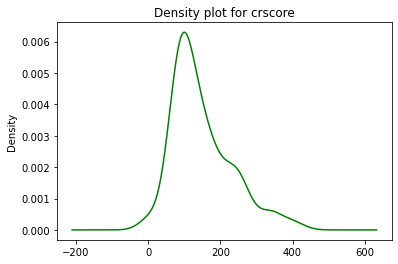

In [99]:
df_univ_rank.crscore.plot.density(color='green')
plt.title('Density plot for crscore')
plt.show()

<AxesSubplot:xlabel='rank', ylabel='crscore'>

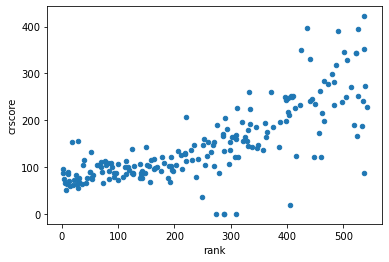

In [100]:
df_univ_rank.plot.scatter(x="rank",y="crscore")

In [96]:
df_univ_rank["rank"][0]

'164'